In [1]:
!wget -c http://download.tensorflow.org/example_images/flower_photos.tgz -O - | tar -xz
#!tar -xzvf flower_photos.tgz

--2020-12-03 14:52:41--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘STDOUT’

-                   100%[===================>] 218.21M  88.7MB/s    in 2.5s    

2020-12-03 14:52:44 (88.7 MB/s) - written to stdout [228813984/228813984]



In [2]:
import cupy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import os.path

np.random.seed(50)

CATEGORIES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

IMG_SIZE = 32

def get_data(DATADIR, raw_training_data, raw_testing_data):
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

        count = 0

        for img in sorted(tqdm(os.listdir(path))):
            try:

                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                count+=1
                if count < num_files-99:
                    raw_training_data.append([new_array, class_num])
                else:
                    raw_testing_data.append([new_array, class_num])
            except Exception as e:
                pass

raw_training_data = []
raw_testing_data = []

DATADIR = "flower_photos"

get_data(DATADIR, raw_training_data, raw_testing_data)


print(len(raw_training_data), len(raw_testing_data))

100%|██████████| 799/799 [00:00<00:00, 772355.13it/s]


3170 500


In [3]:
from sklearn.utils import shuffle
from typing import Tuple

X_TRAIN = []
Y_TRAIN = []

X_TEST = []
Y_TEST = []

X_VAL = []
Y_VAL = []


for features,label in raw_training_data:
    X_TRAIN.append(features)
    Y_TRAIN.append(label)


for features,label in raw_testing_data:
    X_TEST.append(features)
    Y_TEST.append(label)

X_TRAIN = np.array(X_TRAIN).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_TEST = np.array(X_TEST).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_TRAIN = np.array(Y_TRAIN)
X_TRAIN, Y_TRAIN = shuffle(X_TRAIN, Y_TRAIN)

X_TRAIN = X_TRAIN.astype(float) / 255.
X_TEST = X_TEST.astype(float) / 255.


X_TRAIN, X_VAL = X_TRAIN[:-500], X_TRAIN[-500:]
Y_TRAIN, Y_VAL = Y_TRAIN[:-500], Y_TRAIN[-500:]

"""
np.save('xtest.npy',X_TEST)
np.save('ytest.npy',Y_TEST)
"""

print (X_TRAIN.shape, X_VAL.shape)

(2670, 32, 32, 3) (500, 32, 32, 3)


In [4]:
class conv_layer():

    def __init__(self, total_filters, filter_shape, lrate = 0.1, padding = 'no_padding', stride = 1, beta1 = 0.9, beta2 = 0.999):
        self.filters_ws = np.random.randn(*filter_shape, total_filters) * 0.1
        self.filter_bs = np.random.randn(total_filters) * 0.1
        self.padding = padding
        self.stride = stride
        self.din_dw = None 
        self.din_db = None
        self.input = None
        self.mo = 0
        self.acc = 0
        self.mo_b = 0
        self.acc_b = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr = lr

    def forward(self, input, training):
        #print(self.filters_ws)
        self.input = np.array(input, copy=True)


        ############### getting output dimentions here ###############
        n, input_dim_h, input_dim_w, _ = input.shape
        filter_dim_h, filter_dim_w, _, filter_dim_n = self.filters_ws.shape
        if self.padding == 'keep_img_dim':
            output_shape = n, input_dim_h, input_dim_w, filter_dim_n
            filter_dim_h, filter_dim_w, _, _ = self.filters_ws.shape
            p_value = (filter_dim_h - 1) // 2, (filter_dim_w - 1) // 2
        elif self.padding == 'no_padding':
            out_dim_h = (input_dim_h - filter_dim_h) // self.stride + 1
            out_dim_w = (input_dim_w - filter_dim_w) // self.stride + 1
            output_shape = n, out_dim_h, out_dim_w, filter_dim_n
            p_value = 0, 0
        ############### got output dimentions ###############

        out_dim_n, out_dim_h, out_dim_w, out_dim_c = output_shape

        input_padded = self.pad(input, p_value)
        output = np.zeros(output_shape)

        for i in range(out_dim_h):
            for j in range(out_dim_w):
                start_pix_x = i * self.stride
                end_pix_x = start_pix_x + filter_dim_h
                start_pix_y = j * self.stride
                end_pix_y = start_pix_y + filter_dim_w

                output[:, i, j, :] = np.sum(
                    input_padded[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :, np.newaxis] *
                    self.filters_ws[np.newaxis, :, :, :],
                    axis=(1, 2, 3)
                )

        #print(output)
        return output + self.filter_bs

    def backward(self, input , grad):
        out_dim_n, out_dim_h, out_dim_w, out_dim_c = grad.shape
        n, input_dim_h, input_dim_w, input_dim_c = self.input.shape
        filter_dim_h, filter_dim_w, _, _ = self.filters_ws.shape


        ############### getting p value here ###############
        if self.padding == 'keep_img_dim':
            p_value = (filter_dim_h - 1) // 2, (filter_dim_w - 1) // 2
        elif self.padding == 'no_padding':
            p_value = 0, 0
        ############### got p value  ###############



        input_padded = self.pad(self.input, p_value)
        output = np.zeros_like(input_padded)
        #print(grad)
        self.din_db = grad.sum(axis=(0, 1, 2)) / n
        self.din_dw = np.zeros_like(self.filters_ws)

        for i in range(out_dim_h):
            for j in range(out_dim_w):
                start_pix_x = i * self.stride
                end_pix_x = start_pix_x + filter_dim_h
                start_pix_y = j * self.stride
                end_pix_y = start_pix_y + filter_dim_w
                output[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :] += np.sum(
                    self.filters_ws[np.newaxis, :, :, :, :] *
                    grad[:, i:i+1, j:j+1, np.newaxis, :],
                    axis=4
                )
                self.din_dw += np.sum(
                    input_padded[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :, np.newaxis] *
                    grad[:, i:i+1, j:j+1, np.newaxis, :],
                    axis=0
                )

        self.din_dw /= n

        #print(self.din_dw)

        ###################### Adam ###############################
        self.mo = self.beta1*self.mo + (1-self.beta1)*(self.din_dw) 
        self.acc = self.beta2*self.acc + (1-self.beta2)*((self.din_dw) *(self.din_dw))
        self.filters_ws += -self.lr * self.mo / (np.sqrt(self.acc) + 1e-7)

        self.mo_b = self.beta1*self.mo_b + (1-self.beta1)*(self.din_db) 
        self.acc_b = self.beta2*self.acc_b + (1-self.beta2)*((self.din_db) *(self.din_db))
        self.filter_bs += -self.lr * self.mo_b / (np.sqrt(self.acc_b) + 1e-7)        
        ###################### Adam ###############################

        return output[:, p_value[0]:p_value[0]+input_dim_h, p_value[1]:p_value[1]+input_dim_w, :]


    @staticmethod
    def pad(array, pad):
        return np.pad(
            array=array,
            pad_width=((0, 0), (pad[0], pad[0]), (pad[1], pad[1]), (0, 0)),
            mode='constant'
        )



In [5]:
class pool_layer():

    def __init__(self, input_dim, stride = 2):
        self.pool_dim = input_dim
        self.stride = stride
        self.input = None
        self.max_pixels = {}

    def forward(self, input, training):
        #print(input.shape)
        self.input = np.array(input, copy=True)
        n, input_dim_h, input_dim_w, c = input.shape
        pool_x_dim, pool_y_dim = self.pool_dim
        out_dim_h = 1 + (input_dim_h - pool_x_dim) // self.stride
        out_dim_w = 1 + (input_dim_w - pool_y_dim) // self.stride
        output = np.zeros((n, out_dim_h, out_dim_w, c))

        for i in range(out_dim_h):
            for j in range(out_dim_w):
                start_pix_x = i * self.stride
                end_pix_x = start_pix_x + pool_x_dim
                start_pix_y = j * self.stride
                end_pix_y = start_pix_y + pool_y_dim
                focus_area = input[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :]
                self.store_max_pixels(focus_area, (i, j))
                output[:, i, j, :] = np.max(focus_area, axis=(1, 2))

        #print(output)
        return output

    def backward(self, input,grad):
        #print(grad)
        output = np.zeros_like(self.input)
        n, out_dim_h, out_dim_w, c = grad.shape
        pool_x_dim, pool_y_dim = self.pool_dim
        for i in range(out_dim_h):
            for j in range(out_dim_w):
                start_pix_x = i * self.stride
                end_pix_x = start_pix_x + pool_x_dim
                start_pix_y = j * self.stride
                end_pix_y = start_pix_y + pool_y_dim
                output[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :] += grad[:, i:i + 1, j:j + 1, :] * self.max_pixels[(i, j)]
        #print(output)
        return output

    def store_max_pixels(self, area_pixels, i_j_location):
        mark_max = np.zeros_like(area_pixels)
        n, h, w, c = area_pixels.shape
        area_pixels = area_pixels.reshape(n, h * w, c)
        max_locations = np.argmax(area_pixels, axis=1)
        n_idx, c_idx = np.indices((n, c))
        mark_max.reshape(n, h * w, c)[n_idx, max_locations, c_idx] = 1
        self.max_pixels[i_j_location] = mark_max



In [6]:
class reshape_layer():

    def __init__(self):
        self.input_shape = ()

    def forward(self, input, training):
        self.input_shape = input.shape
        return np.ravel(input).reshape(input.shape[0], -1)

    def backward(self,input , grad):
        return grad.reshape(self.input_shape)

In [34]:
all_ws = []
class weights_layer():
    def __init__(self, fan_in, fan_out, lr=0.05, beta1 = 0.9, beta2 = 0.999 , lamdaa = 0.0001):
        self.lamdaa = lamdaa
        self.lr = lr
        self.ws = np.random.randn(fan_in, fan_out)/np.sqrt(fan_in)
        self.bs = np.zeros(fan_out)
        self.mo = 0
        self.acc = 0
        self.mo_b = 0
        self.acc_b = 0
        self.beta1 = beta1
        self.beta2 = beta2
        
    def forward(self,input, training):
        #all_ws.append(self.ws)
        #print(input.shape)
        #print(np.dot(input,self.ws) + self.bs)
        return np.dot(input,self.ws) + self.bs
    
    def backward(self,input,grad_output):
        dout_din = np.dot(grad_output, self.ws.T)
        dout_dws = np.dot(input.T, grad_output)
        dout_dbs = grad_output.mean(axis=0)*input.shape[0]
        
        assert dout_dws.shape == self.ws.shape and dout_dbs.shape == self.bs.shape
        #print(dout_dws)
        ###################### Adam ###############################
        self.mo = self.beta1*self.mo + (1-self.beta1)*(dout_dws) 
        self.acc = self.beta2*self.acc + (1-self.beta2)*((dout_dws) *(dout_dws))
        self.ws += -self.lr * self.mo / (np.sqrt(self.acc) + 1e-7)

        self.mo_b = self.beta1*self.mo_b + (1-self.beta1)*(dout_dbs) 
        self.acc_b = self.beta2*self.acc_b + (1-self.beta2)*((dout_dbs) *(dout_dbs))
        self.bs += -self.lr * self.mo_b / (np.sqrt(self.acc_b) + 1e-7) 
        ###################### Adam ###############################
        """
        self.ws = self.ws - self.lr * dout_dws  #+ (self.lamdaa * np.sum(self.ws))/input.shape[0]
        self.bs = self.bs - self.lr * dout_dbs  #+ (self.lamdaa * np.sum(self.bs))/input.shape[0]  
        """
        #print(dout_din)
        return dout_din

In [8]:
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, input, training):
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad

class tanh():
    def __init__(self):
        pass
    def forward(self, input, training):
        return np.tanh(input)

    def backward(self, input, grad_output):
      return grad_output*(1-np.tanh(input)**2)

class sigmoid():
    def __init__(self):
        pass
    def forward(self, input, training):
        return 1/(1+np.exp(-1* input))
    def backward(self, input, grad_output):
        return grad_output * (input*(1-input))


In [9]:
def NLL(expected_probabilities,actual_labels, m, lamdaa = 0.0001):


    correct_prob = expected_probabilities[np.arange(len(expected_probabilities)),actual_labels]

    p = np.exp(correct_prob) / np.sum(np.exp(expected_probabilities),axis=-1)

    loss = -1 * np.log(p)
    
    """
    s_reg = 0
    for i in all_ws:
      s_reg += np.sum(np.square(i))
    """
    

    #print(expected_probabilities)
    return loss #+ (lamdaa * s_reg)/m

def back_NLL(expected_probabilities,actual_labels):

    hotmap = np.zeros_like(expected_probabilities)
    hotmap[np.arange(len(expected_probabilities)),actual_labels] = 1
    
    ratios = np.exp(expected_probabilities) / np.exp(expected_probabilities).sum(axis=-1,keepdims=True)
    
    
    #print((- hotmap + ratios) / expected_probabilities.shape[0]) 
    return (- hotmap + ratios) / expected_probabilities.shape[0]


In [10]:
def run_batch(CNN, X, training):
    all_layers_outputs = []
    received = X
    for layer in CNN:
        all_layers_outputs.append(layer.forward(received, training))
        received = all_layers_outputs[-1]
  
    all_ws=[]
    assert len(all_layers_outputs) == len(CNN)
    
    return all_layers_outputs

def predict(CNN,X, Y, training):
    expected_probabilities = run_batch(CNN,X, training)[-1]
    losses = NLL(expected_probabilities,Y, X.shape[0])
    return (expected_probabilities.argmax(axis=-1) , np.mean(losses))

def train(CNN,X,acutal_labels, training):

    layers_outputs = run_batch(CNN,X, training)
    layers_inputs = [X]+layers_outputs 
    expected_probs = layers_outputs[-1]
    loss = NLL(expected_probs,acutal_labels, X.shape[0])
    loss_grad = back_NLL(expected_probs,acutal_labels)

    for layer_index in range(len(CNN))[::-1]:
        layer = CNN[layer_index]
        loss_grad = layer.backward(layers_inputs[layer_index],loss_grad)
        
    return np.mean(loss)

In [11]:
class dropout_layer():

    def __init__(self, keep_prob):
        self.cutoff_prob = keep_prob
        self.zeros_for_dropped = None

    def forward(self, input, training):
        if training:
            self.zeros_for_dropped = (np.random.rand(*input.shape) < self.cutoff_prob)
            return self.drop(input, self.zeros_for_dropped)
        else:
            return input

    def backward(self, input, grad):
        return self.drop(grad, self.zeros_for_dropped)

    def drop(self, input, zeros_for_dropped):
        input *= zeros_for_dropped
        input /= self.cutoff_prob
        #print(input)
        return input

In [12]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [27]:
max_count = 20
learning_rates = []
train_log = []
val_log = []
train_losses = []
val_losses = []
n_epochs = 3

for count in range(max_count):

  lr = 10**np.random.uniform(-0.5,-4) 
  
  CNN = []

  CNN.append(conv_layer(8, (3,3,3), lr))
  CNN.append(ReLU())
  CNN.append(pool_layer((2,2)))

  CNN.append(conv_layer(16, (3,3,8) , lr))
  CNN.append(ReLU())
  CNN.append(pool_layer((2,2)))


  CNN.append(conv_layer(32, (3,3,16), lr))
  CNN.append(ReLU())
  CNN.append(pool_layer((2,2)))


  CNN.append(reshape_layer())


  CNN.append(weights_layer(128,100,lr))
  CNN.append(ReLU())
  CNN.append(dropout_layer(0.6))
  CNN.append(weights_layer(100,100,lr))
  CNN.append(ReLU())
  CNN.append(dropout_layer(0.6))
  CNN.append(weights_layer(100,5,lr))

  for epoch in range(n_epochs):

    train(CNN,X_TRAIN,Y_TRAIN, 1)

    train_predictions, train_loss = predict(CNN,X_TRAIN, Y_TRAIN, 0)

    val_predictions, val_loss = predict(CNN,X_VAL, Y_VAL, 0)

    train_log.append(np.mean(train_predictions==Y_TRAIN))

    val_log.append(np.mean(val_predictions==Y_VAL))

    train_losses.append(train_loss)

    val_losses.append(val_loss)

    learning_rates.append(lr)

    print("Trial %d epoch %d got t_acc = %f, v_acc = %f, t_loss = %f, and v_loss = %f at lr = %f" % (count, epoch, train_log[-1], train_losses[-1],val_losses[-1], val_log[-1], lr))

print()
print("Got highest train accuracy = %f at lr = %f" % (max(train_log), learning_rates[train_log.index(max(train_log))]))
print("Got highest val accuracy = %f at lr = %f" % (max(val_log), learning_rates[val_log.index(max(val_log))]))
print("Got lowest train loss = %f at lr = %f" % (min(train_losses), learning_rates[train_losses.index(min(train_losses))]))
print("Got lowest val loss = %f at lr = %f" % (min(val_losses), learning_rates[val_losses.index(min(val_losses))]))


Trial 0 epoch 0 got t_acc = 0.171910, v_acc = 1.619114, t_loss = 1.623299, and v_loss = 0.146000 at lr = 0.000132
Trial 0 epoch 1 got t_acc = 0.190637, v_acc = 1.614611, t_loss = 1.617759, and v_loss = 0.156000 at lr = 0.000132
Trial 0 epoch 2 got t_acc = 0.226217, v_acc = 1.610468, t_loss = 1.612454, and v_loss = 0.162000 at lr = 0.000132
Trial 1 epoch 0 got t_acc = 0.246816, v_acc = 4.367752, t_loss = 4.091685, and v_loss = 0.278000 at lr = 0.023338
Trial 1 epoch 1 got t_acc = 0.167790, v_acc = 1.721592, t_loss = 1.732194, and v_loss = 0.186000 at lr = 0.023338
Trial 1 epoch 2 got t_acc = 0.191011, v_acc = 1.633893, t_loss = 1.644695, and v_loss = 0.178000 at lr = 0.023338
Trial 2 epoch 0 got t_acc = 0.246816, v_acc = nan, t_loss = nan, and v_loss = 0.278000 at lr = 0.155307
Trial 2 epoch 1 got t_acc = 0.172285, v_acc = nan, t_loss = nan, and v_loss = 0.146000 at lr = 0.155307
Trial 2 epoch 2 got t_acc = 0.172285, v_acc = nan, t_loss = nan, and v_loss = 0.146000 at lr = 0.155307
Tria

Ran epoch 0 and got t_acc = 0.254682 val_acc = 0.232000, t_loss = 1.604817, v_loss = 1.609838
Ran epoch 1 and got t_acc = 0.273034 val_acc = 0.234000, t_loss = 1.600084, v_loss = 1.608468
Ran epoch 2 and got t_acc = 0.295880 val_acc = 0.248000, t_loss = 1.596331, v_loss = 1.606108
Ran epoch 3 and got t_acc = 0.301124 val_acc = 0.248000, t_loss = 1.592504, v_loss = 1.602791
Ran epoch 4 and got t_acc = 0.311985 val_acc = 0.264000, t_loss = 1.588075, v_loss = 1.598371
Ran epoch 5 and got t_acc = 0.328464 val_acc = 0.286000, t_loss = 1.583304, v_loss = 1.593106
Ran epoch 6 and got t_acc = 0.339326 val_acc = 0.300000, t_loss = 1.576450, v_loss = 1.586470
Ran epoch 7 and got t_acc = 0.344569 val_acc = 0.302000, t_loss = 1.566671, v_loss = 1.577170
Ran epoch 8 and got t_acc = 0.371161 val_acc = 0.310000, t_loss = 1.552419, v_loss = 1.562606
Ran epoch 9 and got t_acc = 0.374906 val_acc = 0.338000, t_loss = 1.531569, v_loss = 1.541895
Ran epoch 10 and got t_acc = 0.362172 val_acc = 0.352000, t_

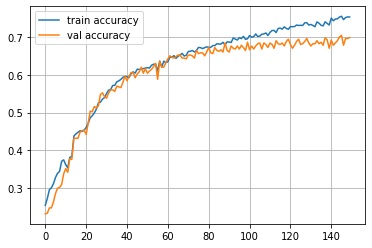

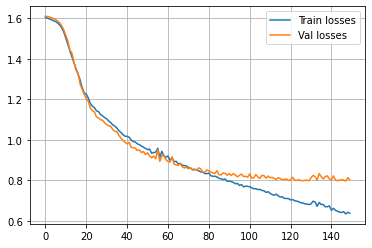


For Q4:
Best train accuracy: 0.7546816479400749
Best val accuracy: 0.704
Lowest Train Loss is 0.633658310877092
Lowest Val Loss is 0.7957766910738746


In [57]:
lr=0.0007

train_log = []
val_log = []
losses = []
train_count = []
counter = 0
train_losses = []
val_losses = []

CNN = []

CNN.append(conv_layer(8, (3,3,3), lr))
CNN.append(ReLU())
CNN.append(pool_layer((2,2)))

CNN.append(conv_layer(16, (3,3,8) , lr))
CNN.append(ReLU())
CNN.append(pool_layer((2,2)))


CNN.append(conv_layer(32, (3,3,16), lr))
CNN.append(ReLU())
CNN.append(pool_layer((2,2)))


CNN.append(reshape_layer())


CNN.append(weights_layer(128,100,lr))
CNN.append(ReLU())
CNN.append(dropout_layer(0.5))
CNN.append(weights_layer(100,100,lr))
CNN.append(ReLU())
CNN.append(dropout_layer(0.5))
CNN.append(weights_layer(100,5,lr))

n_epochs = 150

for epoch in range(n_epochs):
    
    #for x_batch,y_batch in iterate_minibatches(X_TRAIN,Y_TRAIN,batchsize=534,shuffle=True):
    #  train(CNN,x_batch,y_batch, 1)

    train(CNN,X_TRAIN,Y_TRAIN,1)

    train_predictions, train_loss = predict(CNN,X_TRAIN, Y_TRAIN, 0)

    val_predictions, val_loss = predict(CNN,X_VAL, Y_VAL, 0)

    train_log.append(np.mean(train_predictions==Y_TRAIN))

    val_log.append(np.mean(val_predictions==Y_VAL))

    train_losses.append(train_loss)

    val_losses.append(val_loss)

    print("Ran epoch %d and got t_acc = %f val_acc = %f, t_loss = %f, v_loss = %f" % (epoch, train_log[-1], val_log[-1], train_losses[-1], val_losses[-1]))

print()
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.plot(train_losses, label="Train losses") 

plt.plot(val_losses, label="Val losses") 

lowest_train_loss, lowest_val_loss = min(train_losses) , min(val_losses)

plt.grid()

plt.legend() 

lowest_x = val_losses.index(lowest_val_loss)

plt.show() 

print()
print("For Q4:")
print("Best train accuracy:",max(train_log))
print("Best val accuracy:",max(val_log))
print('Lowest Train Loss is ' + str(lowest_train_loss))
print('Lowest Val Loss is ' + str(lowest_val_loss))

For Q5:
For Category  daisy  , Got Accuracy 0.75
For Category  dandelion  , Got Accuracy 0.9
For Category  roses  , Got Accuracy 0.46
For Category  sunflowers  , Got Accuracy 0.83
For Category  tulips  , Got Accuracy 0.6


Text(0.5, 1.0, 'CCR')

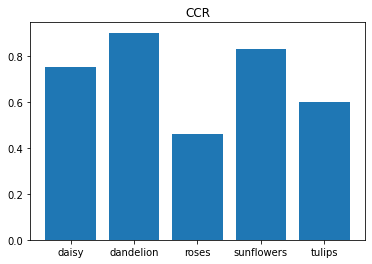

In [58]:
num_partition = 5
x_test_arrays = np.split(X_TEST, num_partition)
y_test_arrays = np.split(np.array(Y_TEST), num_partition)
n_images = len (x_test_arrays[0])

accuracies = []

print ('For Q5:')
for i in range(num_partition):
    class_predictions, class_loss = predict(CNN,x_test_arrays[i], y_test_arrays[i], 0)
    accuracy = np.mean(class_predictions==y_test_arrays[i])
    print('For Category ' , CATEGORIES[i],' , Got Accuracy' , accuracy)
    accuracies.append(accuracy)

y_pos = np.arange(len(CATEGORIES))

plt.bar(CATEGORIES, accuracies)
 
plt.xticks(CATEGORIES, CATEGORIES)
 
plt.title("CCR")



In [59]:
predicted_test, test_loss = predict(CNN,X_TEST, Y_TEST, 0)
accuracy = np.mean(predicted_test==np.array(Y_TEST))
    
print("َََQ6: ACCR = %f" % accuracy)

َََQ6: ACCR = 0.708000
